# Practice Session 09: Forecasting

In this session we will do some time series forecasting on a weather-related time series, which contains temperature, precipitation, and wind speed data for the Barcelona airport. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-11-26</font>

In [1]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

The dataset we will use is was obtained from [AEMET's Open Data](https://opendata.aemet.es/centrodedescargas/inicio) initiative. Anyone can request an API Key and then use their services to obtain climatological variables ("*valores climatológicos*").

We will read it into a dataframe using Pandas' [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [10]:
# LEAVE AS-IS

INPUT_FILE = "aemet-barcelona-airport-2016-2025.json"
weather = pd.read_json(INPUT_FILE)

display(weather.head(5))
display(weather.tail(5))

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
3334,2025-08-19,0076,BARCELONA AEROPUERTO,BARCELONA,4,"27,8","0,7","25,5",Varias,"30,0",...,"4,1","1014,8",Varias,"1009,5",Varias,71.0,82.0,Varias,42.0,08:24
3335,2025-08-20,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,2","32,9","19,8",22:43,"28,5",...,"5,0","1011,2",Varias,"1007,9",17,62.0,94.0,Varias,54.0,11:28
3336,2025-08-21,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,4","0,0","19,5",05:11,"29,2",...,"9,0","1014,2",Varias,"1009,2",04,58.0,92.0,00:19,41.0,14:04
3337,2025-08-22,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,9","0,0","21,3",04:25,"28,5",...,"9,7","1016,0",Varias,"1013,4",04,65.0,82.0,Varias,48.0,09:42
3338,2025-08-23,0076,BARCELONA AEROPUERTO,BARCELONA,4,"25,1","0,0","21,3",05:42,"28,9",...,"11,9","1016,1",Varias,"1013,0",18,71.0,86.0,Varias,60.0,08:48


The columns on this dataset are as follows:

| id          | description                                                         | data_type | units                      |
| ----------- | ------------------------------------------------------------------- | ---------- | --------------------------- |
| fecha       | date (AAAA-MM-DD)                                          | string           |                             |
| indicativo  | *indicativo climatológico*                                            | string           |                             |
| nombre      | name (location) of the station                                   | string           |                             |
| provincia   | province of the station                                            | string           |                             |
| altitud     | altitude of the station above sea level                  | float            | m                           |
| tmed        | average daily temperature                                            | float           | grados celsius              |
| prec        | daily rainfall from 07 to 07                                     | float           | mm (Ip = less than 0.1 mm) |
| tmin        | minimum temperature of the day                                          | float           | ºC                          |
| horatmin    | hour and minute of minimum temperature                              | string          | UTC                         |
| tmax        | maximum temperature of the day                                          | float           | ºC                          |
| horatmax    | hour and minute of maximum temperature                              | string          | UTC                         |
| dir         | direction of the fastest wind gust                                        | float           | decenas de grado            |
| velmedia    | average wind speed                                          | float           | m/s                         |
| racha       | fastest wind gust                                             | float           | m/s                         |
| horaracha   | hour and minute of fastest wind gust                                    | string          | UTC                         |
| sol         | hours of sun                                                            | float           | hours                       |
| presmax     | maximum pressure at the level of reference of the station               | float           | hPa                         |
| horapresmax | hour of maximum pressure (rounded to nearest hour) | string          | UTC                         |
| presmin     | minimum pressure at the level of reference of the station               | float           | hPa                         |
| horapresmin | hour of minimum pressure (rounded to nearest hour) | string          | UTC

Next, we will rename columns so that more people can understand their names, using the following equivalence:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


In [11]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "temp_min_time",
  "horatmax" : "temp_max_time",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "windspeed_gusts_time",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "pressure_max_time",
  "presMin" : "pressure_min",
  "horaPresMin" : "pressure_min_time",
  "hrMedia": "relhumidity_mean",
  "hrMax": "relhumidity_max",
  "hrMin": "relhumidity_min",
  "horaHrMax": "relhumidity_max_time", 
  "horaHrMin": "relhumidity_min_time"
}

<font size="+1" color="red">Replace this cell with your code to rename column names in the resulting dataframe.</font>

In [12]:
df = weather.rename(columns=COLUMN_NAMES)
display(df.head())

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,temp_min_time,temp_max,...,sun,pressure_max,pressure_max_time,pressure_min,pressure_min_time,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="+1" color="red">Replace this cell with your code to drop the station_num, station_name, station_province, station_altitude, and time_* columns, which we will not use, and print the first 10 rows of the data</font>

In [16]:
print(df.columns)
drop_names = ['station_num', 'station_name', 'station_province', 'station_altitude', 
              'temp_min_time', 'temp_max_time', 'windspeed_gusts_time', 
              'pressure_max_time', 'pressure_min_time', 
              'relhumidity_max_time', 'relhumidity_min_time']
df_col_dropped = df.drop(columns=drop_names)
display(df_col_dropped.head())
print(df_col_dropped.columns)
weather = df_col_dropped.copy()

Index(['date', 'station_num', 'station_name', 'station_province',
       'station_altitude', 'temp_avg', 'rainfall', 'temp_min', 'temp_min_time',
       'temp_max', 'temp_max_time', 'windspeed_dir', 'windspeed_avg',
       'windspeed_gusts', 'windspeed_gusts_time', 'sun', 'pressure_max',
       'pressure_max_time', 'pressure_min', 'pressure_min_time',
       'relhumidity_mean', 'relhumidity_max', 'relhumidity_max_time',
       'relhumidity_min', 'relhumidity_min_time'],
      dtype='object')


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",NaN,NaN,NaN,NaN,NaN,NaN


Index(['date', 'temp_avg', 'rainfall', 'temp_min', 'temp_max', 'windspeed_dir',
       'windspeed_avg', 'windspeed_gusts', 'sun', 'pressure_max',
       'pressure_min', 'relhumidity_mean', 'relhumidity_max',
       'relhumidity_min'],
      dtype='object')


The next cell prints the beginning and the end of the time series.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [17]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
3334,2025-08-19,"27,8","0,7","25,5","30,0",34.0,"5,0","12,5","4,1","1014,8","1009,5",71.0,82.0,42.0
3335,2025-08-20,"24,2","32,9","19,8","28,5",4.0,"4,2","14,4","5,0","1011,2","1007,9",62.0,94.0,54.0
3336,2025-08-21,"24,4","0,0","19,5","29,2",99.0,"4,7","8,9","9,0","1014,2","1009,2",58.0,92.0,41.0
3337,2025-08-22,"24,9","0,0","21,3","28,5",35.0,"5,0","10,8","9,7","1016,0","1013,4",65.0,82.0,48.0
3338,2025-08-23,"25,1","0,0","21,3","28,9",24.0,"5,8","11,4","11,9","1016,1","1013,0",71.0,86.0,60.0


Now, we need to process the numerical data. Note that this dataset contains many gaps:

* An instrument may malfunction
* Some variable might not be recorded properly on a given day
* Pressure and relative humidity have only been recorded since around 2019 and 2022, respectively

Create a function ``str_commas_to_float(x)`` that converts numbers with commas, possibly represented as strings, into floating point numbers.

Convert any ``Ip`` to 0.0. Everything else should be converted into **not-a-number** (``np.nan``).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing *str_commas_to_float*.</font>

In [24]:
import re
def str_commas_to_float(x):
    # Case 1: already a float or int → return float
    if isinstance(x, float) or isinstance(x, int):
        return float(x)

    # Case 2: non-string → NaN
    if not isinstance(x, str):
        return np.nan

    # Case 3: string
    x = x.strip()
    if x.lower() == 'ip':
        return 0.0
    try:
        return float(x.replace(',', '.'))
    except:
        return np.nan

Test it with the following cases:

* When giving an empty string, the string "Varias", or the string "06:30", the function should return not a number.
* With the strings "0,0" and "Ip", it should return a zero.
* With a decimal string using a comma (e.g., "13,5") it should return the corresponding number (13.5)
* With an integer as a string (e.g., "13") it should return the corresponding number (13.0)

Use the assert function to do these tests, e.g.:

```python
assert 1 + 1 == 2
```

Use the function [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html) to test whether something is a NaN (not a number) or not.

```python
assert np.isnan(...)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing *str_commas_to_float*.</font>

In [25]:
assert np.isnan(str_commas_to_float(""))
assert np.isnan(str_commas_to_float("Varias"))
assert np.isnan(str_commas_to_float("06:30"))

assert str_commas_to_float("0,0") == 0.0
assert str_commas_to_float("Ip") == 0.0
assert str_commas_to_float("13,5") == 13.5
assert str_commas_to_float("13") == 13.0

# string with space
assert str_commas_to_float(" 13,5 ") == 13.5
assert str_commas_to_float(" Ip ") == 0.0

Apply this function to columns 'temp_min', 'temp_max', 'temp_avg', 'rainfall', 'windspeed_dir', 'windspeed_avg', 'windspeed_gusts', 'pressure_min', 'pressure_max', 'relhumidity_min', 'relhumidity_max'.

To apply function *f* to column *c* of dataframe *df*, we use `df[c] = df[c].apply(f)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code applying the above function to the specified columns.</font>

In [28]:
weather['temp_max'] = weather['temp_max'].apply(str_commas_to_float)
weather['temp_min'] = weather['temp_min'].apply(str_commas_to_float)
weather['temp_avg'] = weather['temp_avg'].apply(str_commas_to_float)
weather['rainfall'] = weather['rainfall'].apply(str_commas_to_float)
weather['windspeed_dir'] = weather['windspeed_dir'].apply(str_commas_to_float)
weather['windspeed_avg'] = weather['windspeed_avg'].apply(str_commas_to_float)
weather['windspeed_gusts'] = weather['windspeed_gusts'].apply(str_commas_to_float)
weather['pressure_max'] = weather['pressure_max'].apply(str_commas_to_float)
weather['pressure_min'] = weather['pressure_min'].apply(str_commas_to_float)
weather['relhumidity_min'] = weather['relhumidity_min'].apply(str_commas_to_float)
weather['relhumidity_max'] = weather['relhumidity_max'].apply(str_commas_to_float)






To verify, we print the first five and last five elements of the time series.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [29]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
3334,2025-08-19,27.8,0.7,25.5,30.0,34.0,5.0,12.5,"4,1",1014.8,1009.5,71.0,82.0,42.0
3335,2025-08-20,24.2,32.9,19.8,28.5,4.0,4.2,14.4,"5,0",1011.2,1007.9,62.0,94.0,54.0
3336,2025-08-21,24.4,0.0,19.5,29.2,99.0,4.7,8.9,"9,0",1014.2,1009.2,58.0,92.0,41.0
3337,2025-08-22,24.9,0.0,21.3,28.5,35.0,5.0,10.8,"9,7",1016.0,1013.4,65.0,82.0,48.0
3338,2025-08-23,25.1,0.0,21.3,28.9,24.0,5.8,11.4,"11,9",1016.1,1013.0,71.0,86.0,60.0


The next code indexes the data by date.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [30]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
display(weather.head(3))

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
date,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN


The following functions, which you can leave as-is, are useful for plotting.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [31]:
# LEAVE THIS CELL AS-IS

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

# Flexible plotting function

def plot_min_max(df, min_col='', max_col='', avg_col='', avg_label='Average', 
                     title='Weather', xlabel='Date', ylabel='Variable'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    if avg_col:
        plt.plot_date(df.index, df[avg_col],
                      fmt='.-', color='black', label=avg_label)
    if min_col and max_col:
        plt.fill_between(df.index, df[min_col], df[max_col],
                         color='lightgray')
    if avg_col:
        plt.legend()

    # Label axis
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
# Simple version


# Plot function
def plot_variable(df, col='', label='', title='Weather', xlabel='Date', ylabel=''):
    
    plot_min_max(df, title=title, xlabel=xlabel, ylabel=ylabel, avg_col=col, avg_label=label)

    plt.show()


We can now plot some values. Note that there are gaps in the temperature series, particularly on the first half of 2018.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

C:\Users\zsy\AppData\Local\Temp\ipykernel_11876\2683894200.py:18: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df.index, df[avg_col],


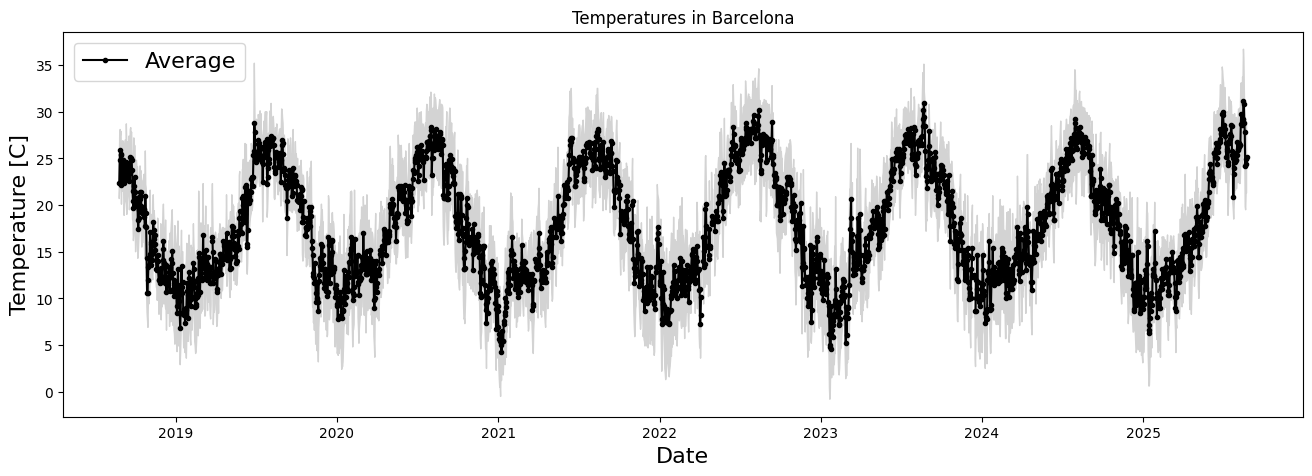

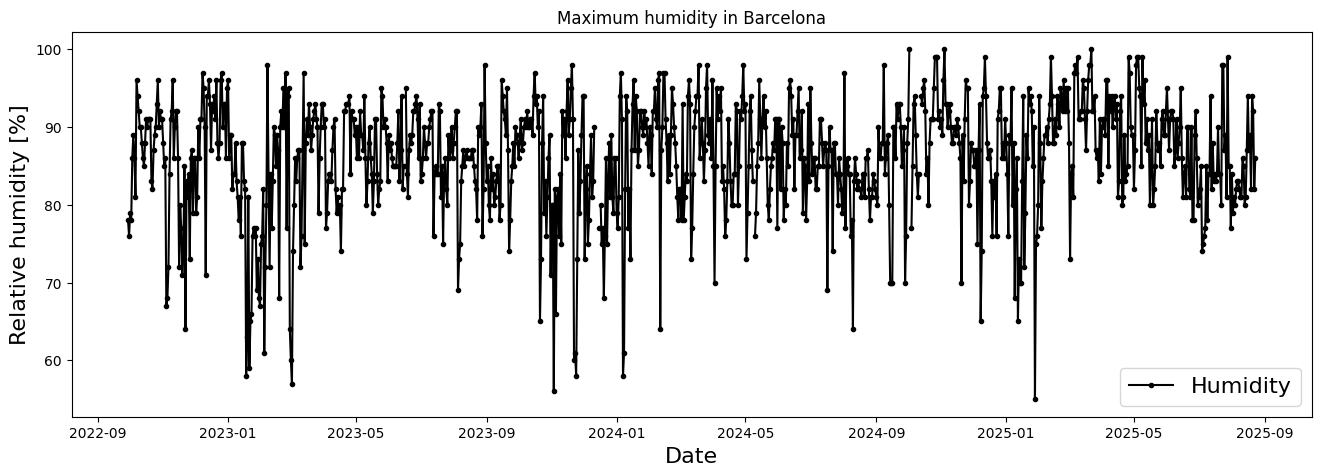

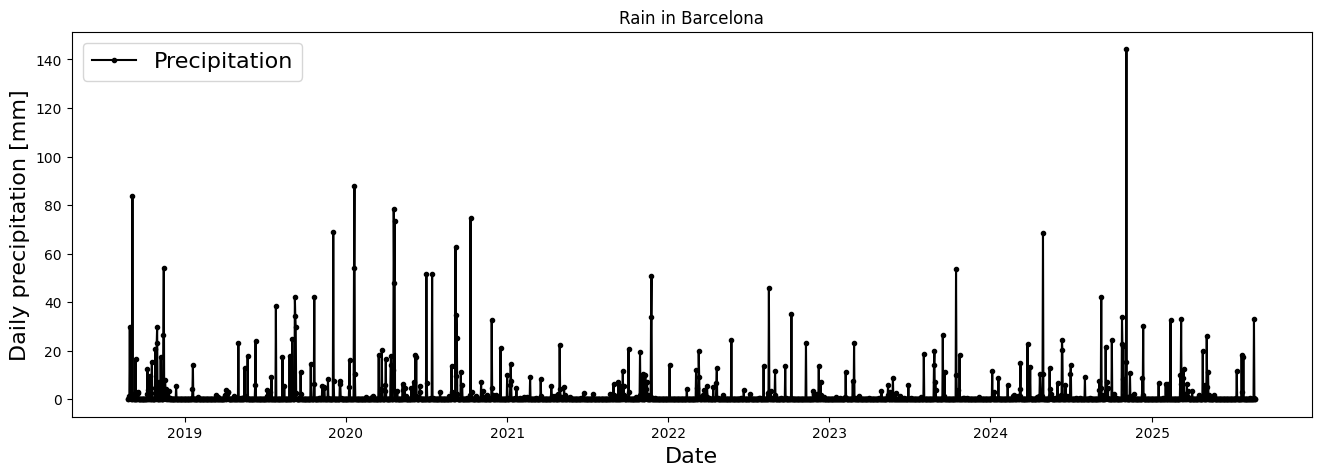

In [32]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather.tail(7*365)

# Plot temperature
plot_min_max(weather_sample, title='Temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Rain in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')


<font size="+1" color="red">Replace this cell with a brief commentary on these three plots. Answer the following: do you observe seasonality in some/all of these plots? Can you describe what type of seasonality do you observe in that one?</font>

# 1. Smooth this series

The original series has strong variations from one day to the next one, so we will smooth the series before using it. Here we will use three smoothing methods: moving averages, binning by floating time periods, and binning by calendar time periods.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 1.1 Smooth the series using moving averages

We will compute a moving average of the previous `window_size` days (e.g., 7) as a way of smoothing the time series. Create a function `moving_average(df, window_size)` that computes a **moving average on all columns** of the given dataframe, and returs a new dataframe with the averages. This function can assume that all columns in the input dataframe are numeric.

A possible implementation is to iterate through numbers from `0` to `len(df)` and create a sub-dataframe of up to `window_size` rows with the corresponding rows. If you choose to implement in this way, you can use the following template:

```python
def moving_average(df, window_size):

    averages = []
    
    for i in range(len(df)):
        
        # Extract a window from the dataframe
        # YOUR CODE HERE
        
        # Compute the average
        average = window.mean(numeric_only=True)
        
        # Append the average to the list of averages
        averages.append(average)

    # Create the dataframe that will be returned
    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed
```

The following might be helpful:

* `window = df.iloc[a:b]` to return rows from *a* to *b* on a dataframe.
* `window.mean(numeric_only=True)` to obtain a series containing the averages of all columns in a dataframe.

If you feel more comfortable working with matrices, you can also use matrices instead of dataframes, and you can also instead of creating a sub-dataframe compute in-place.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your implementation of "moving_average"</font>

In [33]:
def moving_average(df, window_size):

    averages = []
    
    for i in range(len(df)):
        
        # Extract a window from the dataframe
        # YOUR CODE HERE
        start = max(0, i - window_size + 1)
        end = i + 1
        window = df.iloc[start : end]
        # Compute the average
        average = window.mean(numeric_only=True)
        
        # Append the average to the list of averages
        averages.append(average)

    # Create the dataframe that will be returned
    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed

Apply this code over the `weather`  correct by verifying the following:

* For day 1, it should be equivalent to the original series
* For day 2, it should be the average of the first two days of the original series
* For day 7, it should be the average of the first 7 days of the original series
* For day 8, it should be the average of the second to the eight day of the original series
* For the last day, it should be the average of the last 7 days in the series

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [34]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
date,,,,,,,,,,,,,
2016-07-01,24.100000,0.000000,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.350000,0.000000,22.100000,26.650000,56.000000,3.350000,6.650000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,24.033333,0.000000,22.033333,26.066667,44.000000,3.633333,7.400000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-04,23.975000,0.000000,21.975000,26.025000,39.250000,3.550000,7.225000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-05,24.240000,0.000000,22.220000,26.300000,38.400000,3.460000,7.060000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,24.500000,0.000000,22.366667,26.666667,35.333333,3.716667,7.833333,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-07,24.628571,0.000000,22.557143,26.728571,44.428571,3.742857,8.185714,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-08,24.928571,0.014286,22.857143,27.028571,33.571429,3.657143,8.871429,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-09,25.214286,0.014286,23.214286,27.242857,34.285714,3.585714,8.757143,NaN,NaN,NaN,NaN,NaN,NaN


Now we plot the resulting series, observing that it is, well, smoother.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

C:\Users\zsy\AppData\Local\Temp\ipykernel_11876\2683894200.py:18: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df.index, df[avg_col],


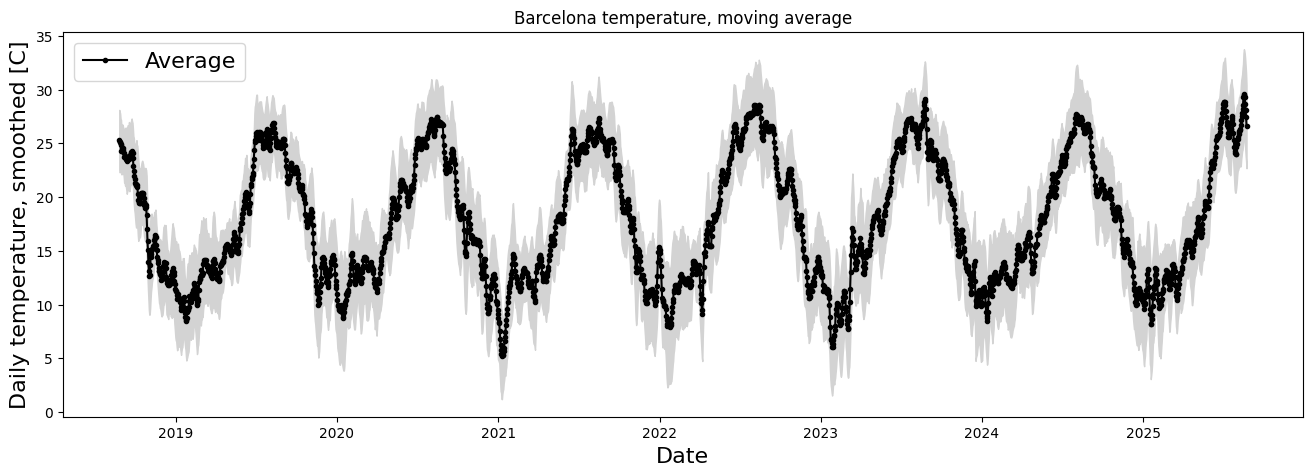

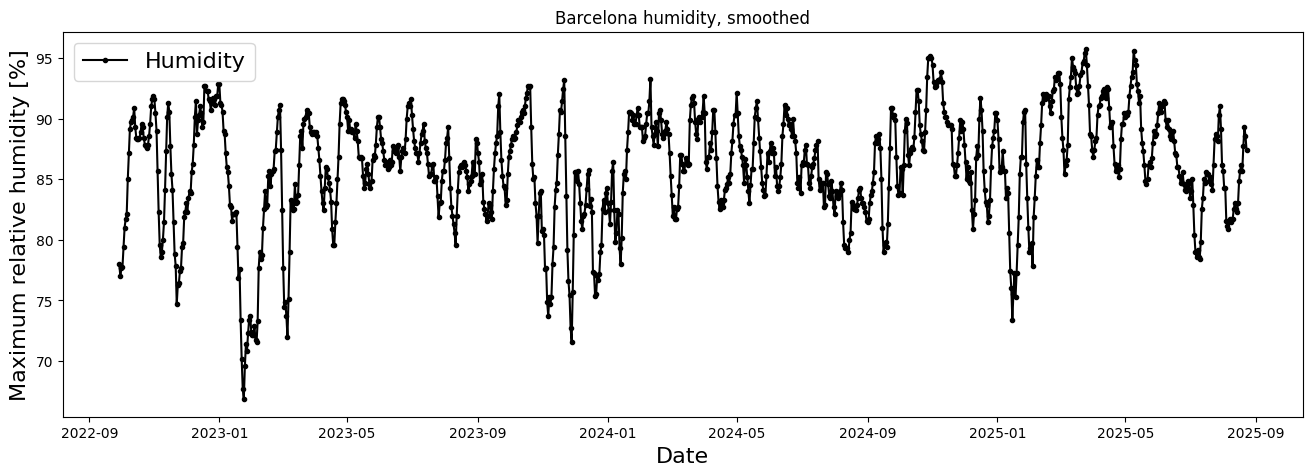

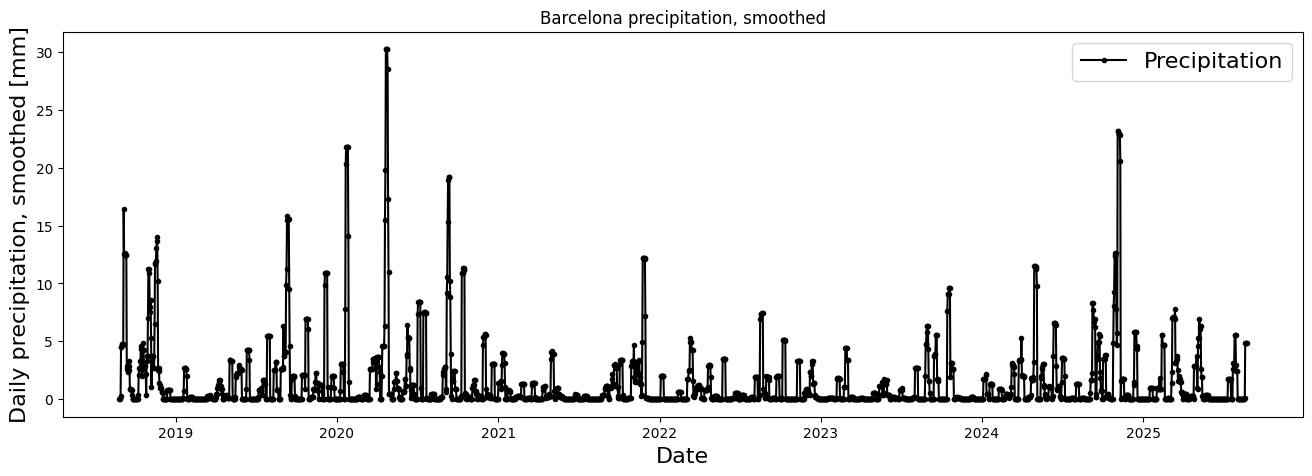

In [35]:
# LEAVE AS-IS

# Sample last 7 years
weather_smoothed_sample = weather_smoothed.tail(7*365)

# Plot smoothed temperature
plot_min_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot smoothed humidity
plot_variable(weather_smoothed_sample,
              title="Barcelona humidity, smoothed", 
                col="relhumidity_max", label="Humidity", ylabel="Maximum relative humidity [%]")

# Plot smoothed precipitation
plot_variable(weather_smoothed_sample,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1" color="red">Replace this cell with a brief commentary indicating what are the key difficulties when implementing a function for "moving_average"</font>

Next, test what happens if you repeat the moving average process many times.

For this, remember to create a copy of the original dataset, so you don't modify your original dataset:

```python
test = weather.copy()
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code that creates a separate ``test`` dataset, and smooths this ``test`` dataset 20 times. **Do not modify your original dataset**, this is just a test. Plot the smoothed daily temperature and smoothed daily precipitation in the ``test`` dataset.</font>

In [39]:
test = weather.copy()
smooth_times = 20
for _ in range(smooth_times):
    test = moving_average(test, window_size)



C:\Users\zsy\AppData\Local\Temp\ipykernel_11876\2683894200.py:18: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df.index, df[avg_col],


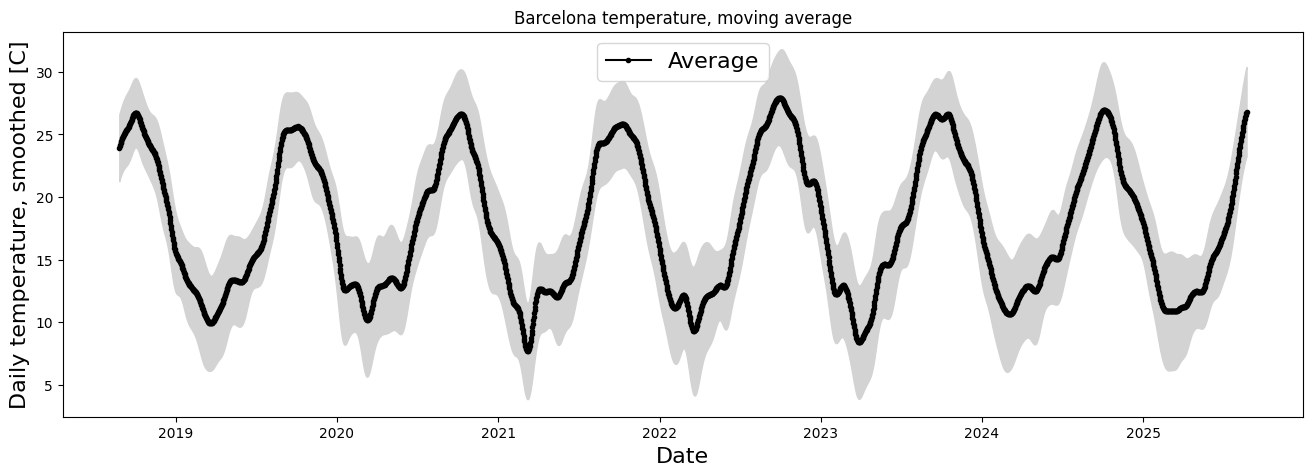

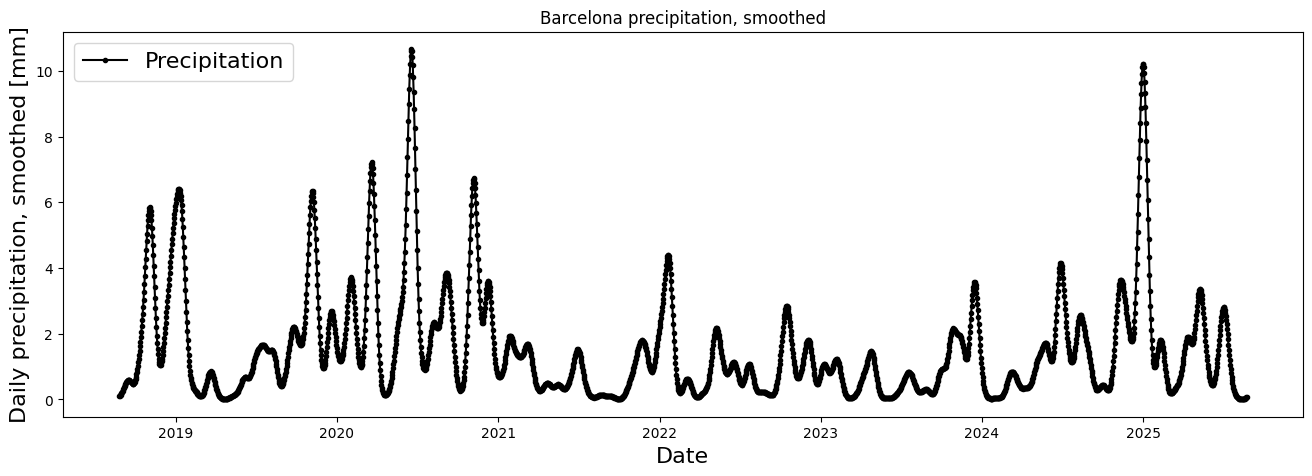

In [40]:
# Sample last 7 years
test_smoothed_sample = test.tail(7*365)

# Plot smoothed temperature
plot_min_max(test_smoothed_sample, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot smoothed precipitation
plot_variable(test_smoothed_sample,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see in the repeatedly smoothed dataset. Why does this happen?</font>

## 1.2. Smooth the series by binning per floating weeks

Note: Pandas have powerful methods for [re-sampling a series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) that we will **not** use. Instead, we want to understand every step of the resampling process.

First, we build a list of `weeks` that starts with the first day of the studied period and then adds one week until passing over the last day of the studied period.

You can use the following template:

```python
def list_of_floating_week_starts(first, last):
    weeks = []
    
    # YOUR CODE HERE
    
    return(weeks)
```

In the list that should be generated:

* The first element should be *first*
* The next elements should be *first + 1 week*, *first + 2 weeks*, ...
* The last element should be in the week after *last*

To add one week to date *D*, use `D + datetime.timedelta(weeks=1)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "list_of_floating_week_starts"</font>

In [ ]:
def list_of_floating_week_starts(first, last):
    weeks = []
    
    # YOUR CODE HERE
    
    return(weeks)

There should be **479** week starts in your dataset, if you have just 478, you need to add one more in the end, it will make your life easier. Note these weeks *float* because they do not start in the calendar start of the week, such as Monday.
 
 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

# Remember that our data frame is indexedb by date
first_day = np.min(weather.index)
last_day = np.max(weather.index)

# Obtain the list of weeks
weeks = list_of_floating_week_starts(first_day, last_day)

# Print the list of weeks
print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" %
      (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

Now, we find the week that corresponds to every element in the time_series.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

Third, we create a new dataframe with the average temperature (min, avg, max), and the total rainfall per floating week.

You can solve this by creating a matrix and then converting into a dataframe.

You can also use Panda's [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function together with the [aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) function. There are many different ways of passing parameters to `aggregate`, check the one in which you pass a dictionary in which the keys are column names and the values are functions (in this case, you should use `np.mean` for `temp_*` and `np.sum` for `rainfall`).

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to generate the "weather_per_floating_week" dataframe</font>

In [ ]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(7*52)

# Plot temperature
plot_min_max(weather_sample, title='Weekly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Weekly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Weekly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

<font size="+1" color="red">Replace this cell with a brief commentary of what you observe on these plots.</font>

## 1.3. Smooth the series by binning per month

Now we repeat the process for months instead of weeks. Now, however, we want to align with the **beginning of a calendar month**.

Create the function `list_of_month_starts(first, last)`. It should return an array containing entries of the form *Year-Month-01*, that is the first of every month. It should start with the first of the month of the first observation, and end with the first of the month following the last observation.

* Given date D, to obtain the first of the month use `D1 = D.replace(day=1)`
* Given date D, to obtain the same date in the next month:
   * If *D.month < 12*, use `D2 = D.replace(month=D.month+1)`
   * If *D.month == 12*, use `D2 = D.replace(year=D.year+1, month=1)`

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

You should obtain **111** month starts. The first month should start on *2016-07-01* and the last month start on *2025-09-01*. Note that the last month may start after the end of the series. 

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

As before, we create a dataframe with the month start.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

As before, aggregate per month to create a dataframe with averages of `temp_min`, `temp_avg`, and `temp_max` per month, and sum of `rainfall`.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to generate the "weather_per_month" dataframe</font>

In [ ]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather_per_month.tail(7*12)

# Plot temperature
plot_min_max(weather_sample, title='Monthly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Monthly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Monthly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

<font size="+1" color="red">Replace this cell with a brief commentary of what you observe on these plots.</font>

# 2. Perform forecasting

We will next perform a simple auto-regressive forecasting.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Compute auto-correlation plots

We will start by computing auto-correlation plots, which show to what extent a series is correlated with itself if we consider a certain `lag`, or time difference.

The function `lagged_series` returns the original series trimmed so it is the same length of the lagged series, and the lagged series computed by looking at *lag* periods in the past. 

You can use the following template:

```python
def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        # but only if j is in [0, len(series)-1]
    return original_trimmed, lagged
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "lagged_series"</font>

Test your function with the following code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


The function `autocorrelation`, which you can leave as-is, simply computes Pearson's correlation between a series and the series lagged *lag* periods.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

Now we will create auto-correlation plots. Create a function `compute_autocorrelations(series, max_periods)` that returns all the auto-correlations of a series from period `0` to `max_periods-1`.

Use this function to create an array `auto_correlation_temp` containing the correlations of `weather['temp_avg']`, `auto_correlation_temp_max` containing the correlations of `weather['temp_max']`, and an array `auto_correlation_rainfall` containing the correlations of `weather['rainfall']`.

Use `max_periods=2*365`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to compute "auto_correlations_temp" and "auto_correlations_rainfall"</font>

Now we plot these.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [ ]:
# LEAVE AS-IS

# Plot max temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_max, ylabel="Autocorrelation (temperature max)")

# Plot avg temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_avg, ylabel="Autocorrelation (temperature avg)")

# Plot max relative humidity auto-correlation
plot_auto_correlations(auto_correlations_relhumidity, ylabel="Autocorrelation (max relative humidity)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see on these plots. (1) What do these autocorrelations indicate about the temperature data? (2) What do these autocorrelations indicate about the humidity data? (3) What do these autocorrelations indicate about the precipitation data? (4) Based on what you see in the autocorrelation plot, what is more unpredictable, humidity or precipitation?</font>

It might be the case that aggregating by week we obtain a stronger auto-correlation of the precipitation time series. Let us try it.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see on this plot. Do you think the correlations you observe in the weekly time series of precipitation (aside from the one at lag=1) come from a real phenomenon, or are spurious? Why?</font>

## 2.2. Prepare a system of equations to learn an auto-regressive model

We will now learn an auto-regressive model, which computes the current value from a series of values in the past, at different *lags*.

**Example:** In the explanation we will assume there are two lags (2, 3) only. This means that the value will be predicted on the basis of the value observed 2 and 3 periods ago. The equation is then *y[i] = y[i-2] x alpha + y[i-3] x beta*, with *alpha* and *beta* being two unknown coefficients that we must determine. Suppose the series is: [11, 19, 32, 38, 51, 58, 68, 81]. From this series, we create the following system of equations.

* 19 x alpha + 11 x beta = 38
* 32 x alpha + 19 x beta = 51
* ...
* 58 x alpha + 51 x beta = 81

Unless the data is generated by a very specific process, we will seldom satisfy this system of equations, but we can approximately satisfy it. We will use SciKit's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to obtain *alpha* and *beta*. To use this function, we need to prepare to matrices: *X*, which will contain the numbers in the left side of the equations, and *y* which will be a vector containing the numbers in the right side of the equations.

Create a function `prepare_matrices`. You can use the following template:

```python
def prepare_matrices(series, lags):
    y = []
    X = []
    
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    for i in range(np.max(lags), len(series)):
        # YOUR CODE HERE
        
        X.append(row)
        y.append(series[i])
        
    return X, y
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "prepare_matrices"</font>

Test your code. Given the series `[11, 15, 32, 37, 52, 54, 70, 89]` and lags `[2, 3]`, you should obtain:

```
X=[[15, 11], [32, 15], [37, 32], [52, 37], [54, 52]]
y=[37, 52, 54, 70, 89]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, 37, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

Notice that your code must handle well missing values. If any of the equations contains a NaN in the left or right side, you should discard it. In other words, X cannot contains vectors that have NaN values, and y cannot contain NaN values.

For instance, given the series `[11, 15, 32, np.nan, 52, 54, 70, 89]` and lags `[2, 3]`, you should obtain:

```
X=[[32, 15], [54, 52]]
y=[52, 89]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, np.nan, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

## 2.3. Perform forecasts

We first define a couple of functions to perform and plot the forecast, which you can leave as-is.

Function `perform_forecast` simply uses your `prepare_matrices` function to prepare a system of equations, and then calls [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in SciKit-Learn to try to find a solution.

We measured the error as RMSE (Root Mean Squared Error) divided by the difference between the maximum and minimum value we want to predict. See [NRMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation#Normalized_root-mean-square_deviation).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='green', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

First, predict the monthly temperature. Set `lags_monthly_temperature = [...]` to be an array of up to 4 lags. Use the auto-correlation plots you draw before as a guideline.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your choice for "lags_monthly_temperature"</font>

In [ ]:
# LEAVE AS-IS

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'],
                                      lags_monthly_temperature)

plot_forecast(y, y_pred,
              xlabel="Period [months]",
              ylabel="Monthly temperature [C]",
              nrmsd=nrmsd)

<font size="+1" color="red">Replace this cell with code and plots predicting: (1) weekly temperature, (2) daily temperature. Always use up to 4 lags, and try to find the lags leading to the smaller error.</font>

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe when predicting temperature.</font>

<font size="+1" color="red">Replace this cell with code and plots predicting: (1) monthly relative humidity, i.e., monthly average of maximum relative humidity, (2) weekly relative humidity, (3) daily relative humidity. Always use up to 4 lags, and try to find the lags leading to the smaller error.</font>

<font size="+1" color="red">Replace this cell with a brief commentary, in your own words, on what you observe when trying to predict relative humidity, in comparison with trying to predict temperature.</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, create a model for temperature that uses cross-correlations. This means, you can use the variables *temp_min*, *temp_avg*, *temp_max*, *rainfall*, *relhumidity_min*, *relhumidity_max*, *windspeed_avg*, and *windspeed_gusts* up to the previous day to predict *temp_avg* on the current day. You only need to be careful not to include any `lag=0` measure, otherwise you would not be predicting the future. Include plots and a brief commentary indicating whether you obtained any improvements.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: cross correlations</font>`` at the top of your notebook. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>